In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('media_test_100.csv')  # Update the path if necessary

# Select relevant columns
texts = data['Artikeltext_Auto']
labels = data['V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant']

# Drop rows with NaN labels
filtered_data = data.dropna(subset=['V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant'])

# Extract texts and labels again after filtering out NaNs
texts = filtered_data['Artikeltext_Auto'].reset_index(drop=True)
labels = filtered_data['V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant'].reset_index(drop=True)

# Convert labels to integers (0 or 1)
labels = labels.astype(int)

# Print out the unique values in labels to verify they are 0 and 1
print("Unique values in labels after cleaning:", labels.unique())

# Train-test split (reproducible split with a fixed random state)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Convert labels to integers
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

# Print sizes and a few examples of the split data for verification
print('Train data size:', len(train_labels), 'Test data size:', len(test_labels))
print('Sample training labels:', train_labels.head())
print('Sample testing labels:', test_labels.head())

# Check the distribution of labels in training and test sets
print("Training set label distribution:\n", train_labels.value_counts())
print("Test set label distribution:\n", test_labels.value_counts())


Unique values in labels after cleaning: [0 1]
Train data size: 3047 Test data size: 762
Sample training labels: 3643    0
2981    1
1351    0
3418    0
246     0
Name: V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant, dtype: int32
Sample testing labels: 1011    1
3554    1
3697    1
897     0
3244    0
Name: V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant, dtype: int32
Training set label distribution:
 V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant
0    2124
1     923
Name: count, dtype: int64
Test set label distribution:
 V9_KKI_Relevanz \n0 = nicht relevant, 1 = relevant
0    558
1    204
Name: count, dtype: int64


In [2]:
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd

# Function to prepare and tokenize datasets based on the given model and tokenizer
def prepare_dataset(train_texts, test_texts, train_labels, test_labels, model_id):
    # Load the tokenizer specific to the model
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True)

    # Prepare the datasets
    train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
    test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))

    # Verify the initial state of datasets
    print("Initial train dataset sample:")
    print(train_dataset[0])
    print("Initial test dataset sample:")
    print(test_dataset[0])

    # Tokenize the datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Rename the label column to 'labels'
    train_dataset = train_dataset.rename_column("label", "labels")
    test_dataset = test_dataset.rename_column("label", "labels")

    # Print a sample after tokenization
    print("\nTokenized train dataset sample:")
    print(train_dataset[0])
    print("Tokenized test dataset sample:")
    print(test_dataset[0])

    # Set format for PyTorch
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Verify that the labels are correctly included and formatted
    print("\nFinal train dataset sample after format:")
    print(train_dataset[0])
    print("Final test dataset sample after format:")
    print(test_dataset[0])

    return train_dataset, test_dataset


In [3]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Define a reusable function for model training and evaluation with early stopping
def train_and_evaluate(model_id):
    # Prepare the datasets
    train_dataset, test_dataset = prepare_dataset(train_texts, test_texts, train_labels, test_labels, model_id)

    # Load the model specific to the model_id
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, 
        num_labels=2, 
        id2label={0: "not relevant", 1: "relevant"}, 
        label2id={"not relevant": 0, "relevant": 1}
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define the training arguments with early stopping enabled
    training_args = TrainingArguments(
        output_dir=f"{model_id}_finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,  # Early stopping will control this
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=50,
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        save_total_limit=3,  # Keep only the 3 most recent checkpoints
        gradient_accumulation_steps=2,  # To simulate a larger batch size
        lr_scheduler_type="cosine",  # Learning rate scheduler
        push_to_hub=False,
        report_to="none"  # Suppress unwanted logging to services like WandB if not using them
    )

    # Define the metric computation function for macro metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
        acc = accuracy_score(labels, predictions)
        return {"accuracy": acc, "f1_macro": f1, "precision_macro": precision, "recall_macro": recall}

    # Instantiate the Trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
    )

    # Train the model
    train_output = trainer.train()

    # Print training metrics
    print("\nTraining output summary:")
    print(train_output)

    # Evaluate the model on the test set
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_id}: {eval_results}")

    # Additional debug: Check final train/eval loss
    print(f"Final train loss: {train_output.training_loss}")
    print(f"Final evaluation loss: {eval_results['eval_loss']}")


In [4]:
# train_and_evaluate('distilbert-base-german-cased')


In [5]:
# train_and_evaluate('bert-base-german-cased')

In [6]:
# train_and_evaluate('xlm-roberta-base')


In [7]:
# train_and_evaluate('german-nlp-group/electra-base-german-uncased')


In [8]:
# train_and_evaluate('nreimers/mMiniLMv2-L6-H384-distilled-from-XLMR-Large')


Summary of the Variants

DistilBERT and BERT models are standard choices for German text classification.

XLM-Roberta offers a robust multilingual alternative.

Electra models are optimized for efficiency, with small and base versions for different speed and performance trade-offs.

MiniLM provides an even more efficient option, suitable for quick benchmarking.

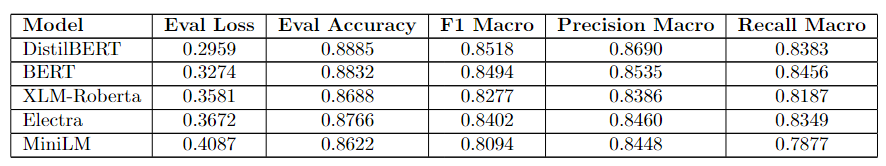

In [9]:
from transformers import AutoModelForSequenceClassification, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_checkpoint(checkpoint_path, model_id):
    # Prepare the datasets (make sure the same train/test split and tokenization as before)
    train_dataset, test_dataset = prepare_dataset(train_texts, test_texts, train_labels, test_labels, model_id)

    # Load the model from the checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Instantiate the Trainer with the loaded model
    trainer = Trainer(
        model=model,
        eval_dataset=test_dataset
    )

    # Evaluate the model and generate predictions
    predictions_output = trainer.predict(test_dataset)
    logits = predictions_output.predictions
    predicted_labels = np.argmax(logits, axis=-1)
    predicted_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()  # Probability for the positive class

    # Actual labels
    true_labels = predictions_output.label_ids

    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Relevant", "Relevant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_id} at checkpoint {checkpoint_path}')
    plt.show()

    # Calculate and plot the ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_id} at checkpoint {checkpoint_path}')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# checkpoint_path = "distilbert-base-german-cased_finetuned/checkpoint-570"
# evaluate_checkpoint(checkpoint_path, 'distilbert-base-german-cased')


Initial train dataset sample:
{'text': 'Seht ihr, Apokalypse, egal, worüber man sich den Kopf zerbricht.', 'label': 0, '__index_level_0__': 3643}
Initial test dataset sample:
{'text': 'Die KI könnte etwa bei Entscheidungen über die Einstellung von Personal oder in der Verwaltung als mögliches Korrektiv oder zweite Meinung zum Einsatz kommen, ohne dass die Entscheidung an das System delegiert würde.', 'label': 1, '__index_level_0__': 1011}


Map:   0%|          | 0/3047 [00:00<?, ? examples/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]


Tokenized train dataset sample:
{'text': 'Seht ihr, Apokalypse, egal, worüber man sich den Kopf zerbricht.', 'labels': 0, '__index_level_0__': 3643, 'input_ids': [102, 23088, 348, 818, 5035, 3932, 1193, 237, 818, 8213, 818, 5928, 278, 545, 251, 190, 3263, 5666, 28749, 566, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/96 [00:00<?, ?it/s]

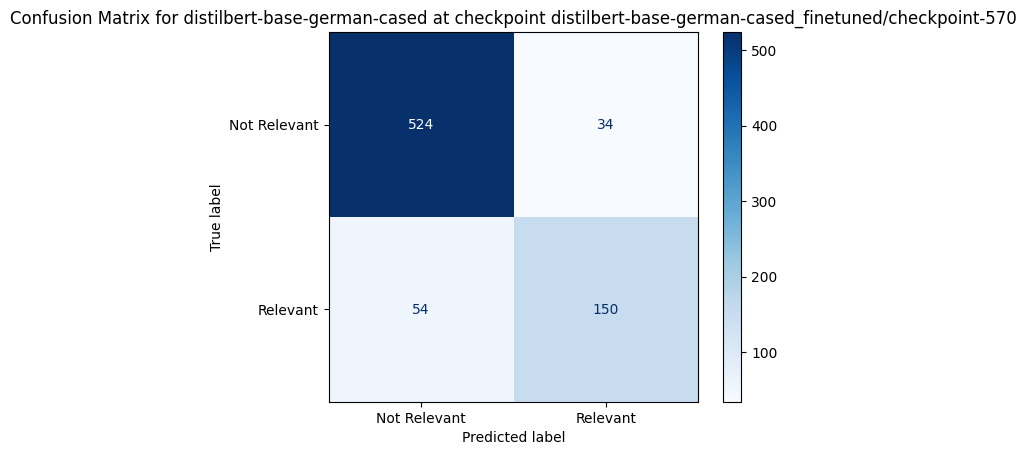

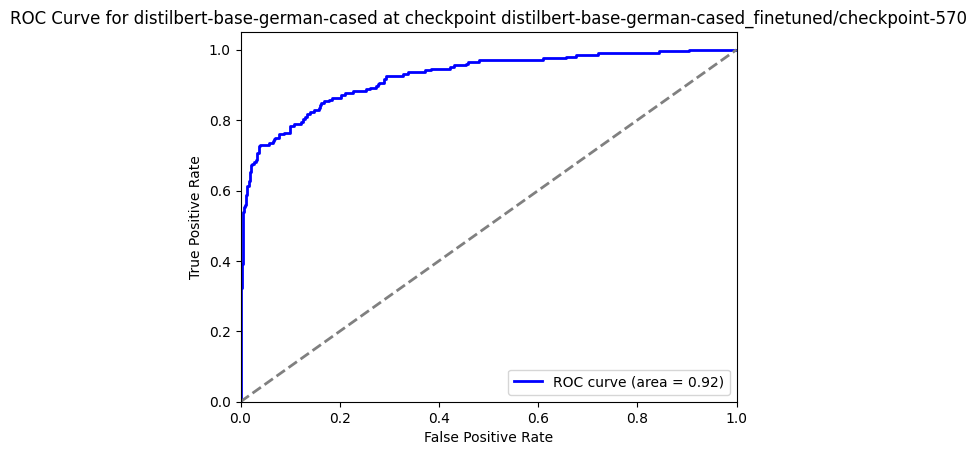

In [10]:
checkpoint_path = "distilbert-base-german-cased_finetuned/checkpoint-570"
evaluate_checkpoint(checkpoint_path, 'distilbert-base-german-cased')

In [11]:
# Text: "Dieses autonome Auto verwendet KI, um die Sicherheit auf den Straßen zu verbessern."
# Text: "Der Kaffee war heute Morgen besonders gut im neuen Café um die Ecke."
# Text: "Ein neues Projekt zur Entwicklung nachhaltiger Technologien wurde in München gestartet."
# Text: "Die Wettervorhersage für morgen ist Regen und niedrige Temperaturen."


# Text: "Forscher haben eine innovative Methode zur Verbesserung der KI-basierten Sprachverarbeitung entwickelt."
# Text: "Das Restaurant hat jetzt eine neue Mittagskarte mit veganen Optionen."
# Text: "In Berlin wurde eine Konferenz über maschinelles Lernen und dessen Anwendungen in der Gesundheitsbranche abgehalten."

# Text: "Die Fußballmannschaft hat das Spiel gestern Abend mit 2:1 gewonnen."
# Text: "Mit dem neuen Algorithmus können Unternehmen ihre Daten effizienter analysieren."
# Text: "Der Film, den ich am Wochenende gesehen habe, war sehr spannend."

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import numpy as np

def load_model_and_tokenizer(checkpoint_path, model_id):
    # Load the tokenizer specific to the model
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Load the model from the checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    return model, tokenizer, device

def predict_text(model, tokenizer, device, text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model output
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1).cpu().numpy()[0]
    return probabilities

def main():
    checkpoint_path = "distilbert-base-german-cased_finetuned/checkpoint-570"
    model_id = 'distilbert-base-german-cased'
    
    # Load model and tokenizer
    model, tokenizer, device = load_model_and_tokenizer(checkpoint_path, model_id)
    
    print("Model loaded. Type a sentence to get a prediction or type 'exit' to quit.")

    while True:
        # Get user input
        text = input("\nEnter a text: ")

        if text.lower() == 'exit':
            print("Exiting the app. Goodbye!")
            break

        # Get prediction
        probabilities = predict_text(model, tokenizer, device, text)

        # Display the result
        print(f"\nPrediction probabilities:")
        print(f"Not Relevant: {probabilities[0]:.4f}")
        print(f"Relevant: {probabilities[1]:.4f}")

if __name__ == "__main__":
    main()
